In [147]:
import torch
import numpy as np
from torch.autograd import Variable
import time
import skvideo.io
from models import UNet11, LinkNet34
from torchvision import transforms
img_transform = transforms.Compose([
    lambda x: x[:544],
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
])

In [148]:
video = skvideo.io.vread('Example/test_video.mp4')

In [150]:
model.eval()
start = time.time()
frames = 0
out = None
for rgb_frame in video:
    input_img = torch.unsqueeze(img_transform(rgb_frame).cuda(), dim=0)
    out = model(input_img)
    frames += 1
end = time.time()    
print("fps: {}".format(frames/(end-start)))

(600, 800, 3)
fps: 0.0


In [ ]:
import glob

In [ ]:
train = glob.glob('data/Train/CameraRGB/*.png')

In [ ]:
val = np.random.choice(train, 80, replace=False)

In [ ]:
val = [f.split('/')[-1] for f in val]

In [ ]:
import shutil

trainRGB = 'data/Train/CameraRGB/'
trainSeg = 'data/Train/CameraSeg/'
valRGB = 'data/Val/CameraRGB/'
valSeg = 'data/Val/CameraSeg/'

for f in val:
    shutil.move(trainRGB+f, valRGB)
    shutil.move(trainSeg+f, valSeg)

In [ ]:
from torchvision import transforms
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        lambda x: x[:544],
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        lambda x: x[:544],
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class UDSegDataset(Dataset):
    def __init__(self, file_names, path, transform):
        self.rgb_file_names = [path + 'CameraRGB/' + f for f in file_names]
        self.seg_file_names = [path + 'CameraSeg/' + f for f in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.rgb_file_names)

    def __getitem__(self, idx):
        bgr_img = cv2.imread(self.rgb_file_names[idx])
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        seg_img = cv2.imread(self.seg_file_names[idx])[:544, :, 2]
        
        img = self.transform(rgb_img)
        road_mask = np.where((seg_img == 7) | (seg_img == 6), 1, 0)
        car_mask = np.where(seg_img == 10, 2, 0)
        car_mask[496:] = 0
#         mask = np.dstack((road_mask, car_mask)).transpose((2, 0, 1))
        mask = road_mask+car_mask
        return img, torch.tensor(mask, dtype=torch.float)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
imshow(img)

In [ ]:
plt.imshow(mask.numpy())

In [1]:
import copy
import torch
import os
import time
import glob
import gc
from torchvision import transforms
from dataset import UDSegDataset
from torch.utils.data import DataLoader
from models import LinkNet34
from loss import LossMulti
import torch.optim as optim

In [2]:
## training loop
w = 800
h = 544
batch_sz = 8

files = { x: [os.path.basename(f) for f in glob.glob(
    'data/'+x+'/CameraRGB/*.png')] for x in {'train', 'val'}}
data_transforms = {
    'train': transforms.Compose([
        lambda x: x[:544],
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        lambda x: x[:544],
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloader = {x: 
              DataLoader(
                  UDSegDataset(files[x], 'data/'+x+'/', data_transforms[x]), 
                  batch_size=8, 
                  shuffle=True, 
#                   num_workers=2
              ) 
              for x in {'train','val'}}

# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs-1))
#         print('-' * 10)
        
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 model.train()
#             else:
#                 model.eval()
                
#             running_loss = 0.0
#             running_corrects = 0.0
            
#             for bi, (inputs, labels) in enumerate(dataloader[phase]):
#                 for obj in gc.get_objects():
#                     if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#                         print(type(obj), obj.size())
#                 print('starting batch {}'.format(bi))
# #                 inputs = inputs.cuda()
# #                 labels = labels.cuda()
                
#                 optimizer.zero_grad()
                
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, dim=1)
#                     loss = criterion(outputs, labels)
                    
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
                        
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
                
#             epoch_loss = running_loss / len(dataloader[phase])
#             epoch_acc = running_corrects.double() / (len(dataloader[phase]) * w * h)
            
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [5]:
model = LinkNet34(num_classes=3).cuda()
criterion = LossMulti(jaccard_weight=1, num_classes=3)
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs=20

In [ ]:
# train_model(model, criterion, optimizer, exp_lr_scheduler)
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for bi, (inputs, labels) in enumerate(dataloader[phase]):

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, dim=1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(dataloader[phase])
        epoch_acc = running_corrects / (len(dataloader[phase]) * batch_sz * w * h)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, './best.pt')
            

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/19
----------
train Loss: 3.7062 Acc: 0.8376
val Loss: 1.7490 Acc: 0.9741

Epoch 1/19
----------
train Loss: 1.7998 Acc: 0.9654
val Loss: 1.3691 Acc: 0.9731

Epoch 2/19
----------
train Loss: 1.4052 Acc: 0.9720
val Loss: 0.6529 Acc: 0.9898

Epoch 3/19
----------
train Loss: 1.2763 Acc: 0.9748
val Loss: 0.6735 Acc: 0.9898

Epoch 4/19
----------
train Loss: 1.1848 Acc: 0.9782
val Loss: 0.4891 Acc: 0.9922

Epoch 5/19
----------
train Loss: 1.1133 Acc: 0.9794
val Loss: 0.5235 Acc: 0.9923

Epoch 6/19
----------
train Loss: 1.1607 Acc: 0.9781
val Loss: 0.5045 Acc: 0.9922

Epoch 7/19
----------
train Loss: 1.0306 Acc: 0.9824
val Loss: 0.3892 Acc: 0.9943

Epoch 8/19
----------
train Loss: 0.9437 Acc: 0.9840
val Loss: 0.3508 Acc: 0.9944

Epoch 9/19
----------
train Loss: 0.8917 Acc: 0.9847
val Loss: 0.3518 Acc: 0.9947

Epoch 10/19
----------


In [ ]:
tdl = dataloader['train']

In [10]:
imgs, masks = None, None
for i, m in tdl:
    imgs, masks = i, m
    break

In [11]:
outputs = model(imgs)

In [12]:
_, preds = torch.max(outputs, dim=1)

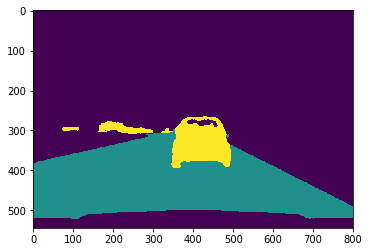

In [15]:
plt.imshow(preds[0].cpu())

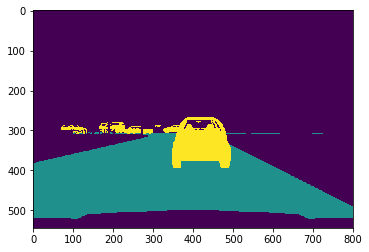

In [16]:
plt.imshow(masks[0].cpu())

In [17]:
import cv2

In [134]:
img = imgs[0].cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
mask = masks[0].cpu().numpy()
my_mask = outputs[0].cpu().detach().numpy()

In [135]:
my_mask = np.argmax(my_mask, axis=0).astype(np.float64)

In [158]:
masked_img = np.copy(img)

In [159]:
masked_img[(my_mask==1).nonzero()] = (0, 0, 1)
masked_img[(my_mask==2).nonzero()] = (0, 1, 0)

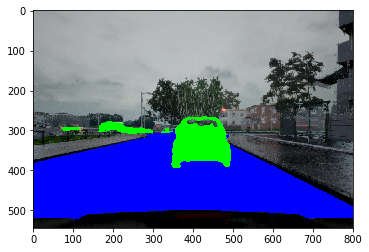

In [160]:
plt.imshow(masked_img)

In [145]:
weighted_img = cv2.addWeighted(img, .7, masked_img, .3, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


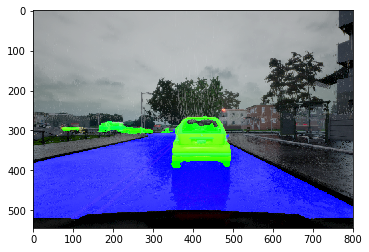

In [146]:
plt.imshow(weighted_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


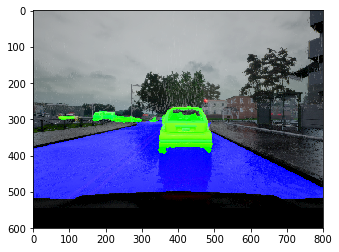

In [156]:
plt.imshow(np.pad(weighted_img, ((0, 56), (0, 0), (0,0)), 'constant', constant_values=(0)))